Copyright 2024 Gabriel Lindenmaier

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
import os
import sys

# In case of Jupyter notebooks leave out the __file__ variable.
# AND ensure that the combination of ".." leads to the root directory
project_root_path = os.path.realpath(os.path.join("../"))
sys.path.append(project_root_path)

import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import sqlite3
import textstat

from collections import Counter
from pathlib import Path

from src.utils.helpers import parallel_pandas
from src.utils.settings import Config
from src.data.spacyoverlay import SpacyOverlay
from src.data.data_exploration import DataExplorer
from src.data.data_filtering import DataFilterer
from src.data.vocab_coverage import VocabCoverage

## Constants & Objects

In [2]:
path_glove = Path(Config.path.data_external) / 'glove.840B.300d.txt'
cpu_cores = Config.hardware.n_cpu
explorer = DataExplorer()
filterer = DataFilterer()

plot_hist = explorer.plot_hist

## Data Loading

In [3]:
data_file = Config.path.data_folder
data_base = Config.path.data_base
sql_query = """
SELECT p.prompt, p.prompt_body, p.story, p.prompt_score, p.story_score
FROM pruned as p
order by p.prompt ASC, p.story_score DESC, p.prompt_score DESC;"""

In [4]:
%%time
conn = sqlite3.connect(data_base)
data = pd.read_sql_query(sql_query, conn)

CPU times: user 1.57 s, sys: 4.11 s, total: 5.68 s
Wall time: 5.69 s


In [5]:
data.describe()   # 373,288 submissions

,prompt_score,story_score
count,366815.000000,366815.000000
mean,1068.216981,30.881728
std,3062.611059,241.217962
min,1.000000,1.000000
25%,9.000000,2.000000
50%,37.000000,3.000000
75%,258.000000,8.000000
max,45824.000000,25202.000000


In [6]:
data.head()

,prompt,prompt_body,story,prompt_score,story_score
0,"P] You are the first sentient robot, a mechani...",,This is the day you get fired.\n\nThis is the ...,28,21
1,"[RF] ""How are you?"" She smiled. I opened my mo...",,"""How are you?"" She smiled, with an insincere s...",7,6
2,"[RF] ""I wear grownup clothes, go to grownup co...",,"Death and taxes, those were the only two thing...",37,5
3,"[RF] ""I wear grownup clothes, go to grownup co...",,Life progresses whether you like it or not and...,37,5
4,"[RF] ""I'd looked at the family photo a hundred...",,"""Hey, do you have few minuets?"" There was a lo...",9,7


# Filter Data

In [7]:
%%time
# Wall time: 7min 17s
filterer.filter_data(data, cpu_cores)



	Runtime of last section: 0.0s
======  COMPUTE STATISTICAL INFORMATION FOR FILTERING  ========================



100%|██████████| 366815/366815 [00:08<00:00, 44821.31it/s]




	Runtime of last section: 140.1s
======  DROP STORIES WITH MORE THAN 10,000 CHARACTERS  ========================



	Runtime of last section: 0.0s
======  KEEP STORIES WITH 1% <= WORD-LENGTH-QUANTILE <= 99%  ==================



	Runtime of last section: 0.1s
======  KEEP STORIES WITH 0.5% <= SPECIAL-CHARS / ALPHA-NUM-CHARS <= 99%  =====



	Runtime of last section: 0.1s
======  KEEP STORIES WITH 0.2% <= UNIQUE-CHARS <= 99.8%  ======================



	Runtime of last section: 0.1s
======  KEEP STORIES WITH 0.1% <= MOST-FREQ-TOKEN / TOTAL_TOKENS <= 99%  ======



	Runtime of last section: 0.1s
======  COMPUTE MORE STATISTICAL INFORMATION FOR FILTERING  ===================



100%|██████████| 349057/349057 [01:31<00:00, 3835.18it/s] 




	Runtime of last section: 296.6s
======  KEEP STORIES WITH MAX-SENTENCE-LENGTH <= 98%  =========================



	Runtime of last section: 0.1s
======  KEEP STORIES WITH AVG-SENTENCE-LENGTH <= 99%  =========================



	Runtime of last section: 0.0s
======  KEEP STORIES WITH 0 <= FLESCH READING EASE SCORE <= 99.9%  ============



	Runtime of last section: 0.1s
======  DROP PROMPTS WITH LESS THAN TWO WORDS AND SEVEN CHARS  ================

CPU times: user 2min 20s, sys: 6.08 s, total: 2min 26s
Wall time: 7min 17s


# Explore Data

In [8]:
data.describe()   # 342,447 submissions

,prompt_score,story_score,story_words,story_chars,story_word_len,story_special_chars,story_alpha_nums,story_sc_by_an,story_unique_chars,story_token_freq,prompt_words,prompt_chars,story_sent_len_avg,story_sent_len_max,story_fres
count,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000,336395.000000
mean,1065.610401,31.716143,548.588460,2920.587408,5.318415,119.107995,2253.890953,0.053689,49.682112,0.073811,27.380288,151.511191,15.386842,39.411763,78.656893
std,3059.235067,245.700676,361.096888,1930.402885,0.243254,87.376009,1494.204423,0.018588,7.761504,0.016885,13.450661,74.528744,4.072012,12.677471,11.535052
min,1.000000,1.000000,19.000000,103.000000,4.668874,6.000000,77.000000,0.017997,30.000000,0.037975,2.000000,8.000000,4.771429,9.000000,0.090000
25%,9.000000,2.000000,277.000000,1469.000000,5.149570,55.000000,1131.000000,0.040094,44.000000,0.061803,17.000000,92.000000,12.470588,30.000000,73.000000
50%,37.000000,3.000000,463.000000,2461.000000,5.304033,96.000000,1897.000000,0.050682,50.000000,0.071032,26.000000,142.000000,14.694444,37.000000,80.110000
75%,258.000000,8.000000,729.000000,3882.000000,5.472727,159.000000,2997.000000,0.064128,55.000000,0.082882,37.000000,206.000000,17.571429,46.000000,86.500000
max,45824.000000,25202.000000,2025.000000,10000.000000,6.091324,839.000000,8093.000000,0.127393,72.000000,0.139344,66.000000,304.000000,31.321429,89.000000,105.280000


## Correlation

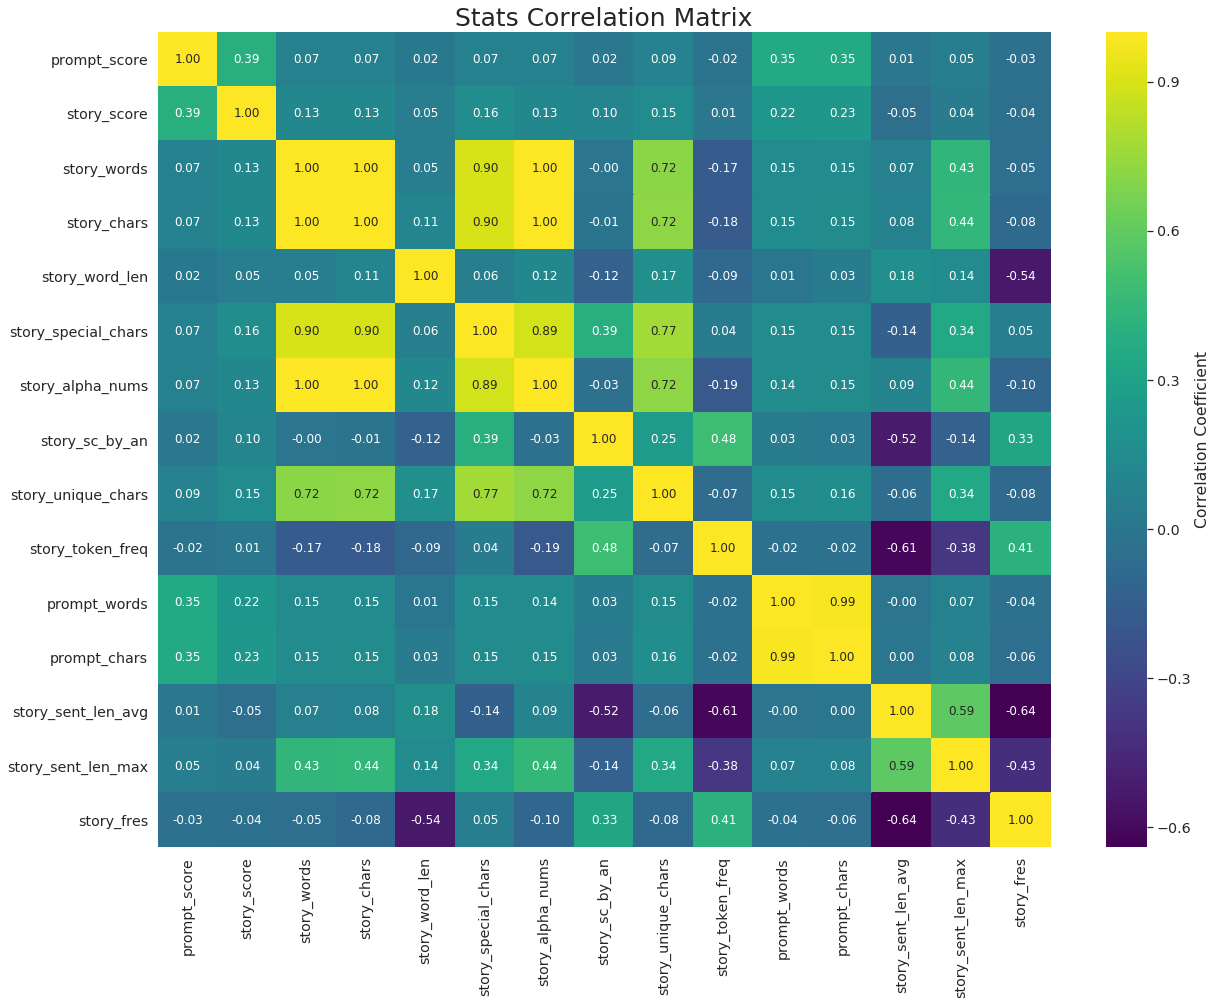

CPU times: user 10.1 s, sys: 1.38 s, total: 11.5 s
Wall time: 9.99 s


In [9]:
%%time
sns.set(font_scale=1.3)
_, ax = plt.subplots(figsize= [20,15])
sns.heatmap(data.corr(method='spearman'), ax=ax
            , annot=True, annot_kws={'fontsize': 12}, fmt='.2f'
            , cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Stats Correlation Matrix", fontsize=25)
plt.show()
plt.close()
sns.set(font_scale=1.0)

## Story Statistics
Words here are defined as character sequences separated by whitespaces

In [10]:
print(f"Story words total: {data.story_words.sum():,}")
# Story words total: 188,271,441

Story words total: 184,542,415


In [11]:
end = 522
df_choice = data[data.story_words <= end]
df_choice = df_choice[df_choice.story_words >= 100]
print(f"Stories & words 100-{end}: {len(df_choice):,} & {df_choice.story_words.sum():,}")
# Stories & words 100-348: 111,761 & 25,664,929
# Stories & words 100-522: 186,897 & 58,122,195
# Stories & words 100-696: 241,236 & 90,939,180
# Stories & words 100-850:  273,374 & 115,633,494
# Stories & words 100-1000: 294,669 & 135,239,459

Stories & words 100-522: 184,063 & 57,191,980


## Story Distributions

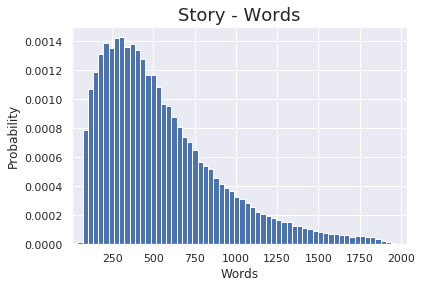

In [12]:
words = data.story_words.values
plot_hist(words, range_=(7, 2037), hist_type='Words', value_src='Story')

Word Definition: All character sequences separated by whitespaces


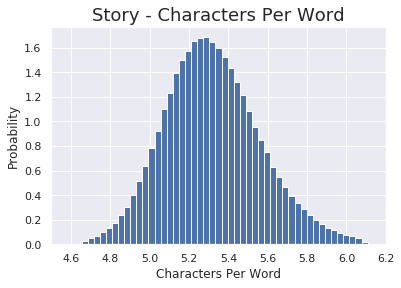

In [13]:
word_len = data.story_word_len.values
print('Word Definition: All character sequences separated by whitespaces')
plot_hist(word_len, range_=(4.5, 6.2), hist_type='Characters Per Word', value_src='Story')

Ratio of special characters - exluding whitespaces - compared to alpha-numeric characters (a-zA-Z-like, 0-9, _)


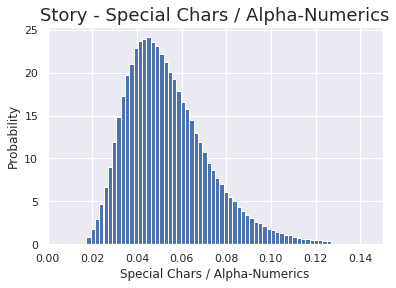

In [14]:
story_sc_by_an = data.story_sc_by_an.values
print('Ratio of special characters - exluding whitespaces - compared to alpha-numeric characters (a-zA-Z-like, 0-9, _)')
plot_hist(story_sc_by_an, range_=(0.0, 0.15), hist_type='Special Chars / Alpha-Numerics', value_src='Story')

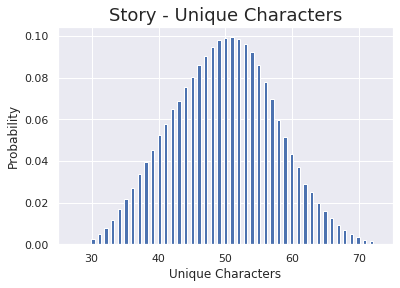

In [15]:
story_unique_chars = data.story_unique_chars.values
plot_hist(story_unique_chars, range_=(25, 75), hist_type='Unique Characters', value_src='Story')

Most occurring token-type in a text / amount of all tokens in a text


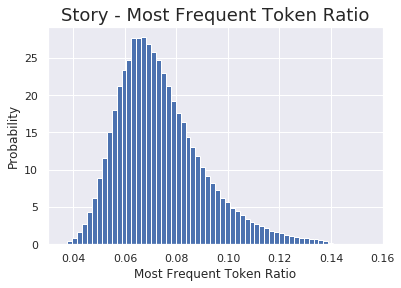

In [16]:
story_token_freq = data.story_token_freq.values
print('Most occurring token-type in a text / amount of all tokens in a text')
plot_hist(story_token_freq, range_=(0.03, 0.16), hist_type='Most Frequent Token Ratio', value_src='Story')

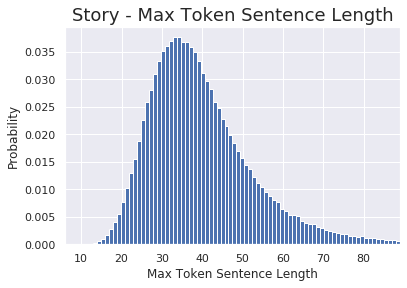

In [17]:
sent_len = data.story_sent_len_max.values
plot_hist(sent_len, range_=(6, 89), hist_type='Max Token Sentence Length', value_src='Story')

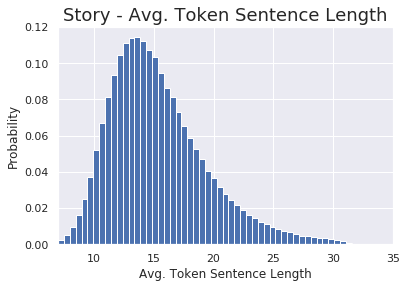

In [18]:
sent_len = data.story_sent_len_avg.values
plot_hist(sent_len, range_=(7, 35), hist_type='Avg. Token Sentence Length', value_src='Story')

 FRES Readability: higher is better


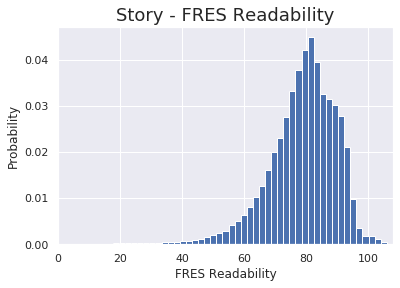

In [19]:
readability = data.story_fres.values
print(' FRES Readability: higher is better')
plot_hist(readability, range_=(0, 108), hist_type='FRES Readability', value_src='Story')

## Prompt Distributions

Word Definition: All character sequences separated by whitespaces


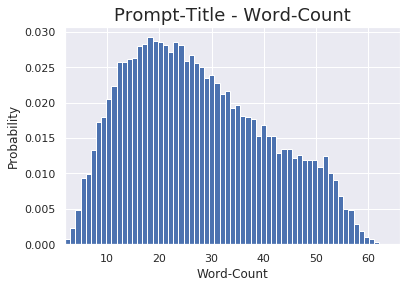

In [20]:
words = data.prompt_words.values
print('Word Definition: All character sequences separated by whitespaces')
plot_hist(words, range_=(2, 66), hist_type='Word-Count', value_src='Prompt-Title')

# Manual Data Exploration

In [21]:
%%time
explorer.find_submissions(data, regex='š', use_regex=True, column='story')

0 appropriate submissions found
CPU times: user 10.6 s, sys: 0 ns, total: 10.6 s
Wall time: 10.6 s


In [22]:
explorer.display_random_submission(df=data)

# Token Stats

In [23]:
%%time
# Wall time: 2min 17s
vocab_cover = VocabCoverage()
l_data = [data["prompt_body"], data["prompt"], data["story"]]
oov_glove = vocab_cover.calculate_oov(l_data, path_glove, vector_count=2196017)
del l_data
# Added 74496 tokens to vocab
# Found tokens for 57.40% of d_vocab
# Found tokens for 99.81% of all text

100%|██████████| 2.20M/2.20M [00:28<00:00, 78.3k vectors/s]


Added 73843 tokens to vocab
Found tokens for 57.51% of d_vocab
Found tokens for 99.81% of all text
CPU times: user 2min 12s, sys: 8.44 s, total: 2min 20s
Wall time: 2min 17s


In [24]:
#oov_glove

In [25]:
del oov_glove

# Write Filtered Data Into Database

In [26]:
%%time
# Wall time: 23.2 s
data.to_sql('filtered', conn)   # , if_exists='replace'

CPU times: user 2.54 s, sys: 2.43 s, total: 4.96 s
Wall time: 5 s
